In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.api import VAR

In [225]:
# Stationarity test
def test_stationarity(timeseries, significance_level=0.05):
    adf_result = adfuller(timeseries.diff().dropna())
    return adf_result[1] < significance_level

In [226]:
# Lag Selection
def select_lag(data, max_lag):
    model = VAR(data)
    best_aic = float('inf')
    best_order = 0
    for lag in range(1, max_lag + 1):
        result = model.fit(lag)
        if result.aic < best_aic:
            best_aic = result.aic
            best_order = lag
    return best_order

In [227]:
# Granger Causality Test
def granger_causality_test(df, tickers, periods, max_lag=12):
    results = pd.DataFrame()
    for period in periods:
        data = df[df.columns]
        for stock1 in tickers:
            for stock2 in tickers:
                if stock1 != stock2:
                    gc_test = grangercausalitytests(data[[stock1, stock2]], maxlag=select_lag(data[[stock1, stock2]], max_lag))
                    for lag in gc_test:
                        f_test_values = gc_test[lag][0]['ssr_ftest']
                        p_values = f_test_values[1]
                        results.loc[f'{stock2} -> {stock1}, ({period})', f'lag_{lag}'] = p_values
    return results

In [228]:
def select_data(data, period):
    if period == '5y':
        return data.tail(5 * 252) 
    elif period == '1y':
       return data.tail(252)
    elif period == '1m':
        return data.tail(20) 
    else:
        raise ValueError("Invalid period. Supported values: '5y', '1y', '1m'")

def visualize_stock_tickers(data, tickers, period):
    num_pairs = len(tickers) * (len(tickers) - 1) // 2
    rows = num_pairs // 3 + 1
    cols = 2

    fig, axs = plt.subplots(rows, cols, figsize=(15, 6 * rows)) 
    axs = axs.flatten()

    pair_index = 0
    for i, stock1 in enumerate(tickers):
        for stock2 in tickers[i+1:]:
            if stock1 != stock2:
                if pair_index >= len(axs):
                    break;
                
                ax = axs[pair_index]
                
                period_data = select_data(data, period)
            
                if period == '1m':
                    my_fmt = mdates.DateFormatter('%m-%d')
                    ax.xaxis.set_major_formatter(my_fmt)
               
                ax.plot(period_data[stock1], label=stock1)
                ax.plot(period_data[stock2], label=stock2)

                ax.set_xlabel('Time')
                ax.set_ylabel('Price')
                ax.legend()
                ax.set_title(f'{stock1} vs. {stock2} Price Over Time ({period})')

                pair_index += 1

    plt.tight_layout()
    plt.show()

In [229]:
def visualize_stock_pairs(stock1, stock2, period):
    period_data_stock1 = select_data(stock1, period)
    period_data_stock2 = select_data(stock2, period)
    
    if period == '1m':
                    my_fmt = mdates.DateFormatter('%m-%d')
                    plt.gca().xaxis.set_major_formatter(my_fmt)

    plt.plot(period_data_stock1, label=stock1.name)
    plt.plot(period_data_stock2, label=stock2.name)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'{stock1.name} vs. {stock2.name} Price Over Time ({period})')
    plt.legend()
    plt.show()

In [230]:
def highlight_table_cells(val, threshold=0.05):
    color = 'yellow' if val < threshold else 'transparent'
    return f'background-color: {color}'

In [231]:
# Data setup
tickers = ['AAPL', 'MSFT', 'GOOGL', 'META']
all_periods = ['5y', '1y', '1m']
data = yf.download(tickers, period='5y', interval='1d')['Adj Close']
data_log = data.apply(np.log)
data_log.index = data.index.to_period('D')

[*********************100%%**********************]  4 of 4 completed


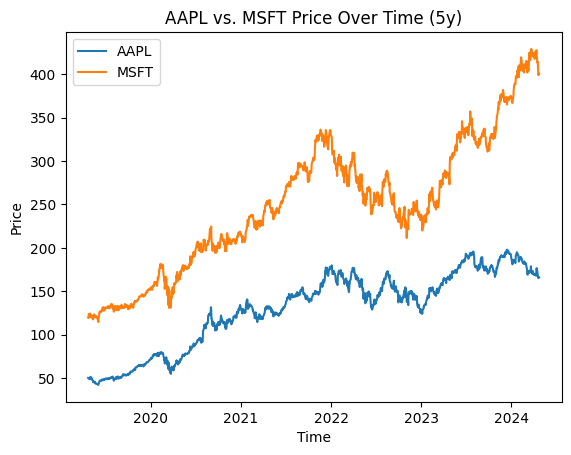

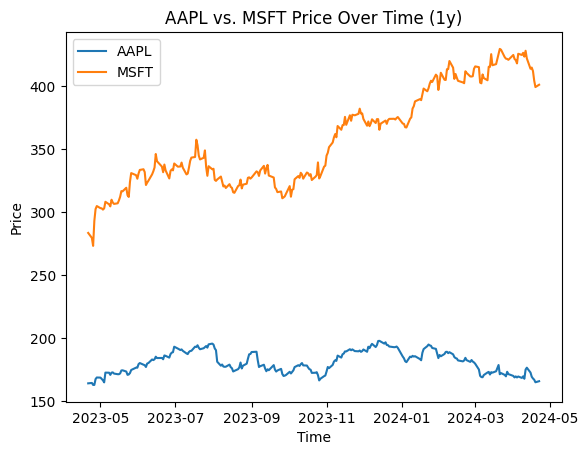

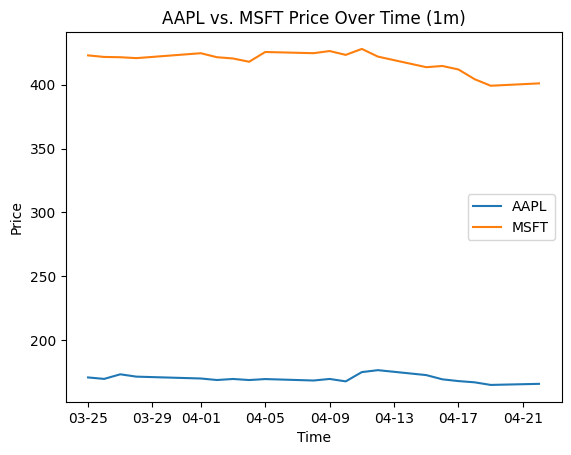

In [232]:
visualize_stock_pairs(data['AAPL'], data['MSFT'], '5y')
visualize_stock_pairs(data['AAPL'], data['MSFT'], '1y')
visualize_stock_pairs(data['AAPL'], data['MSFT'], '1m')

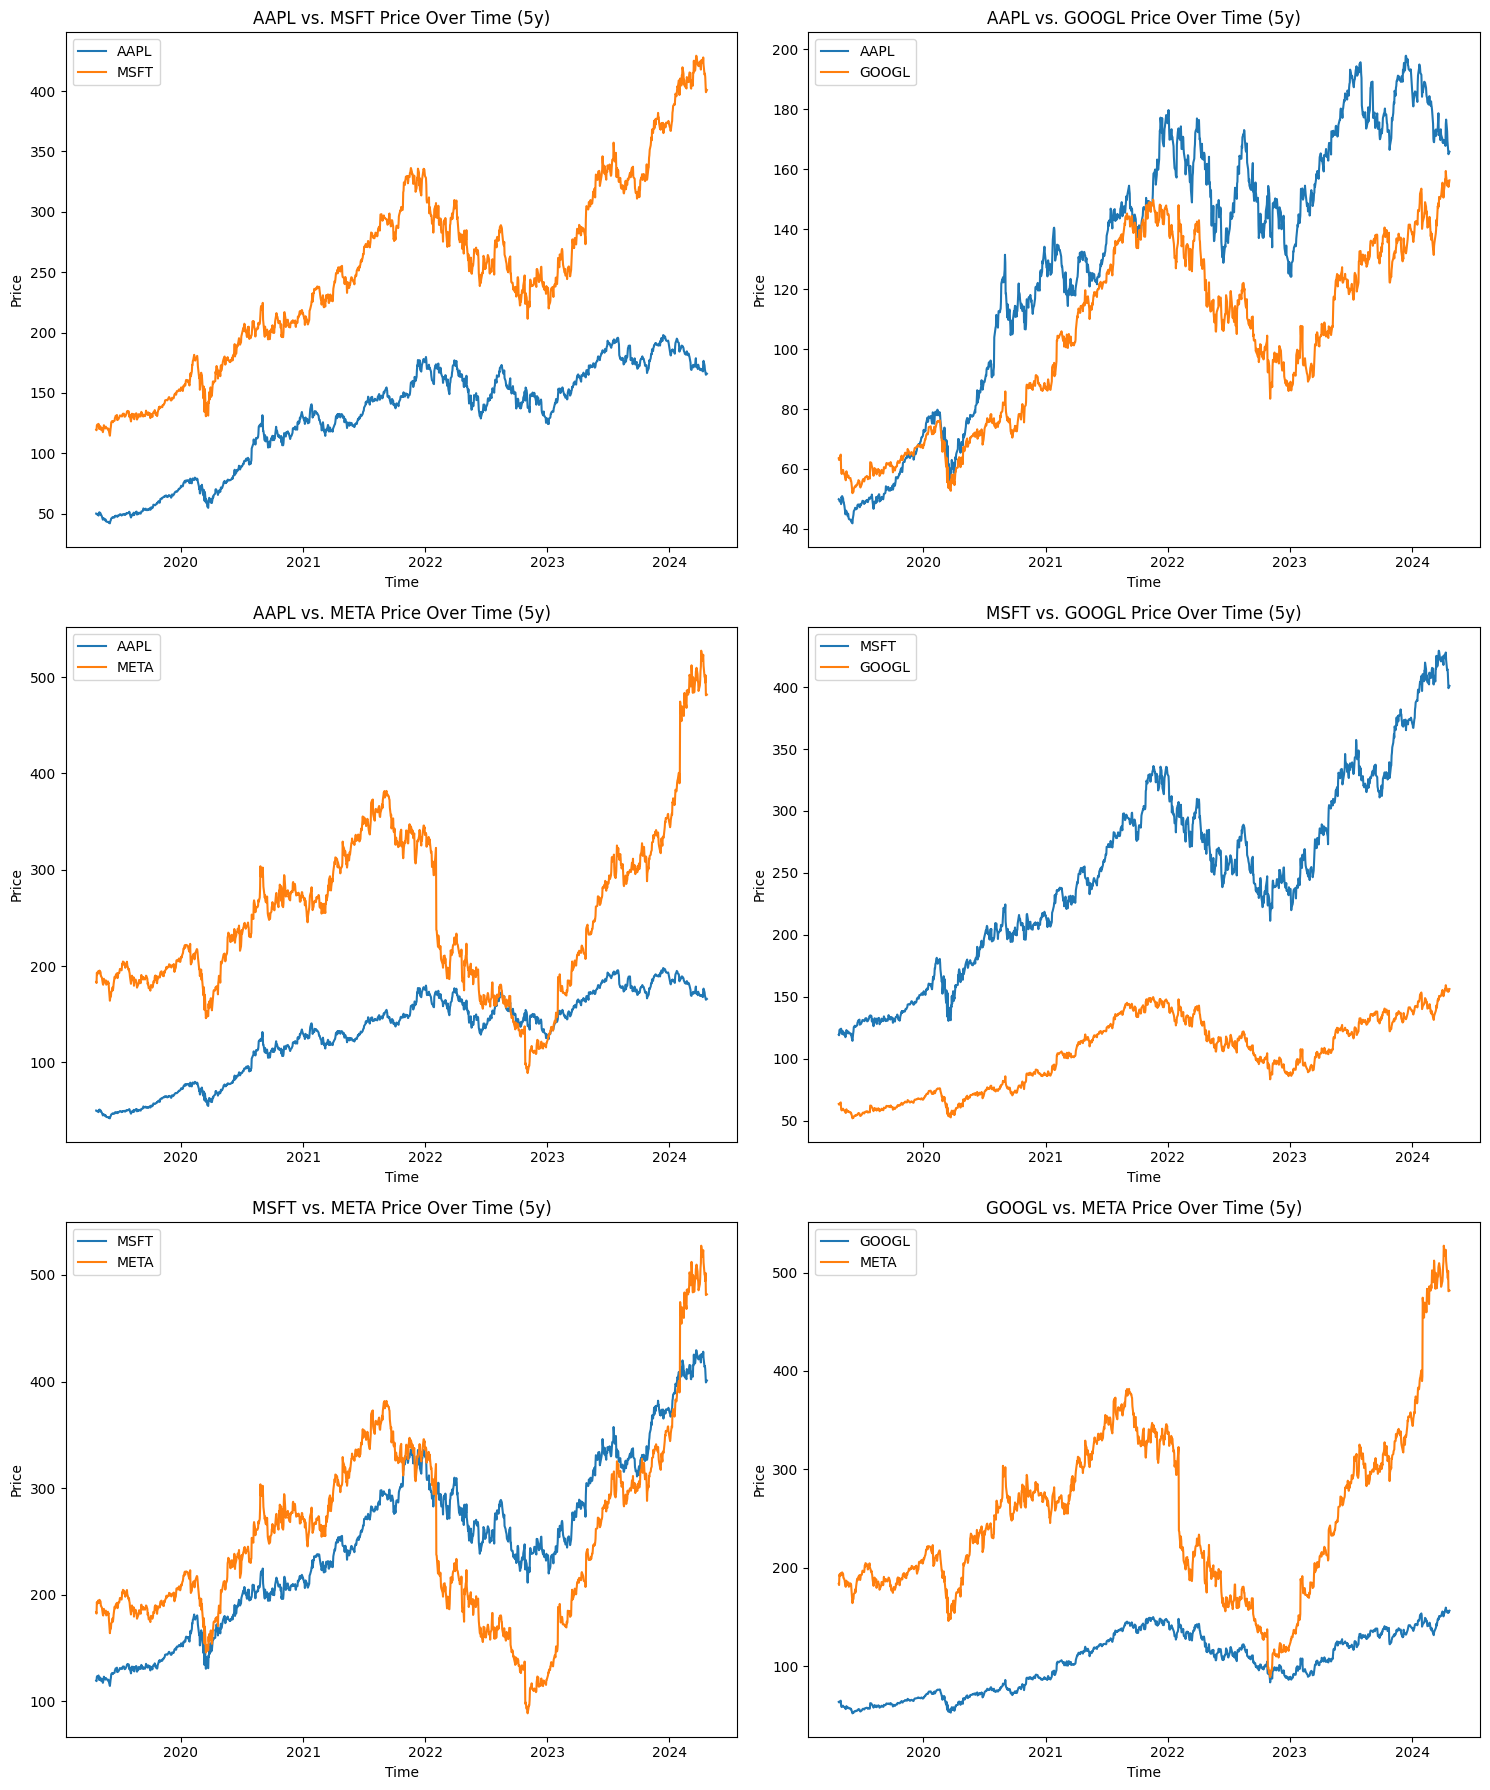

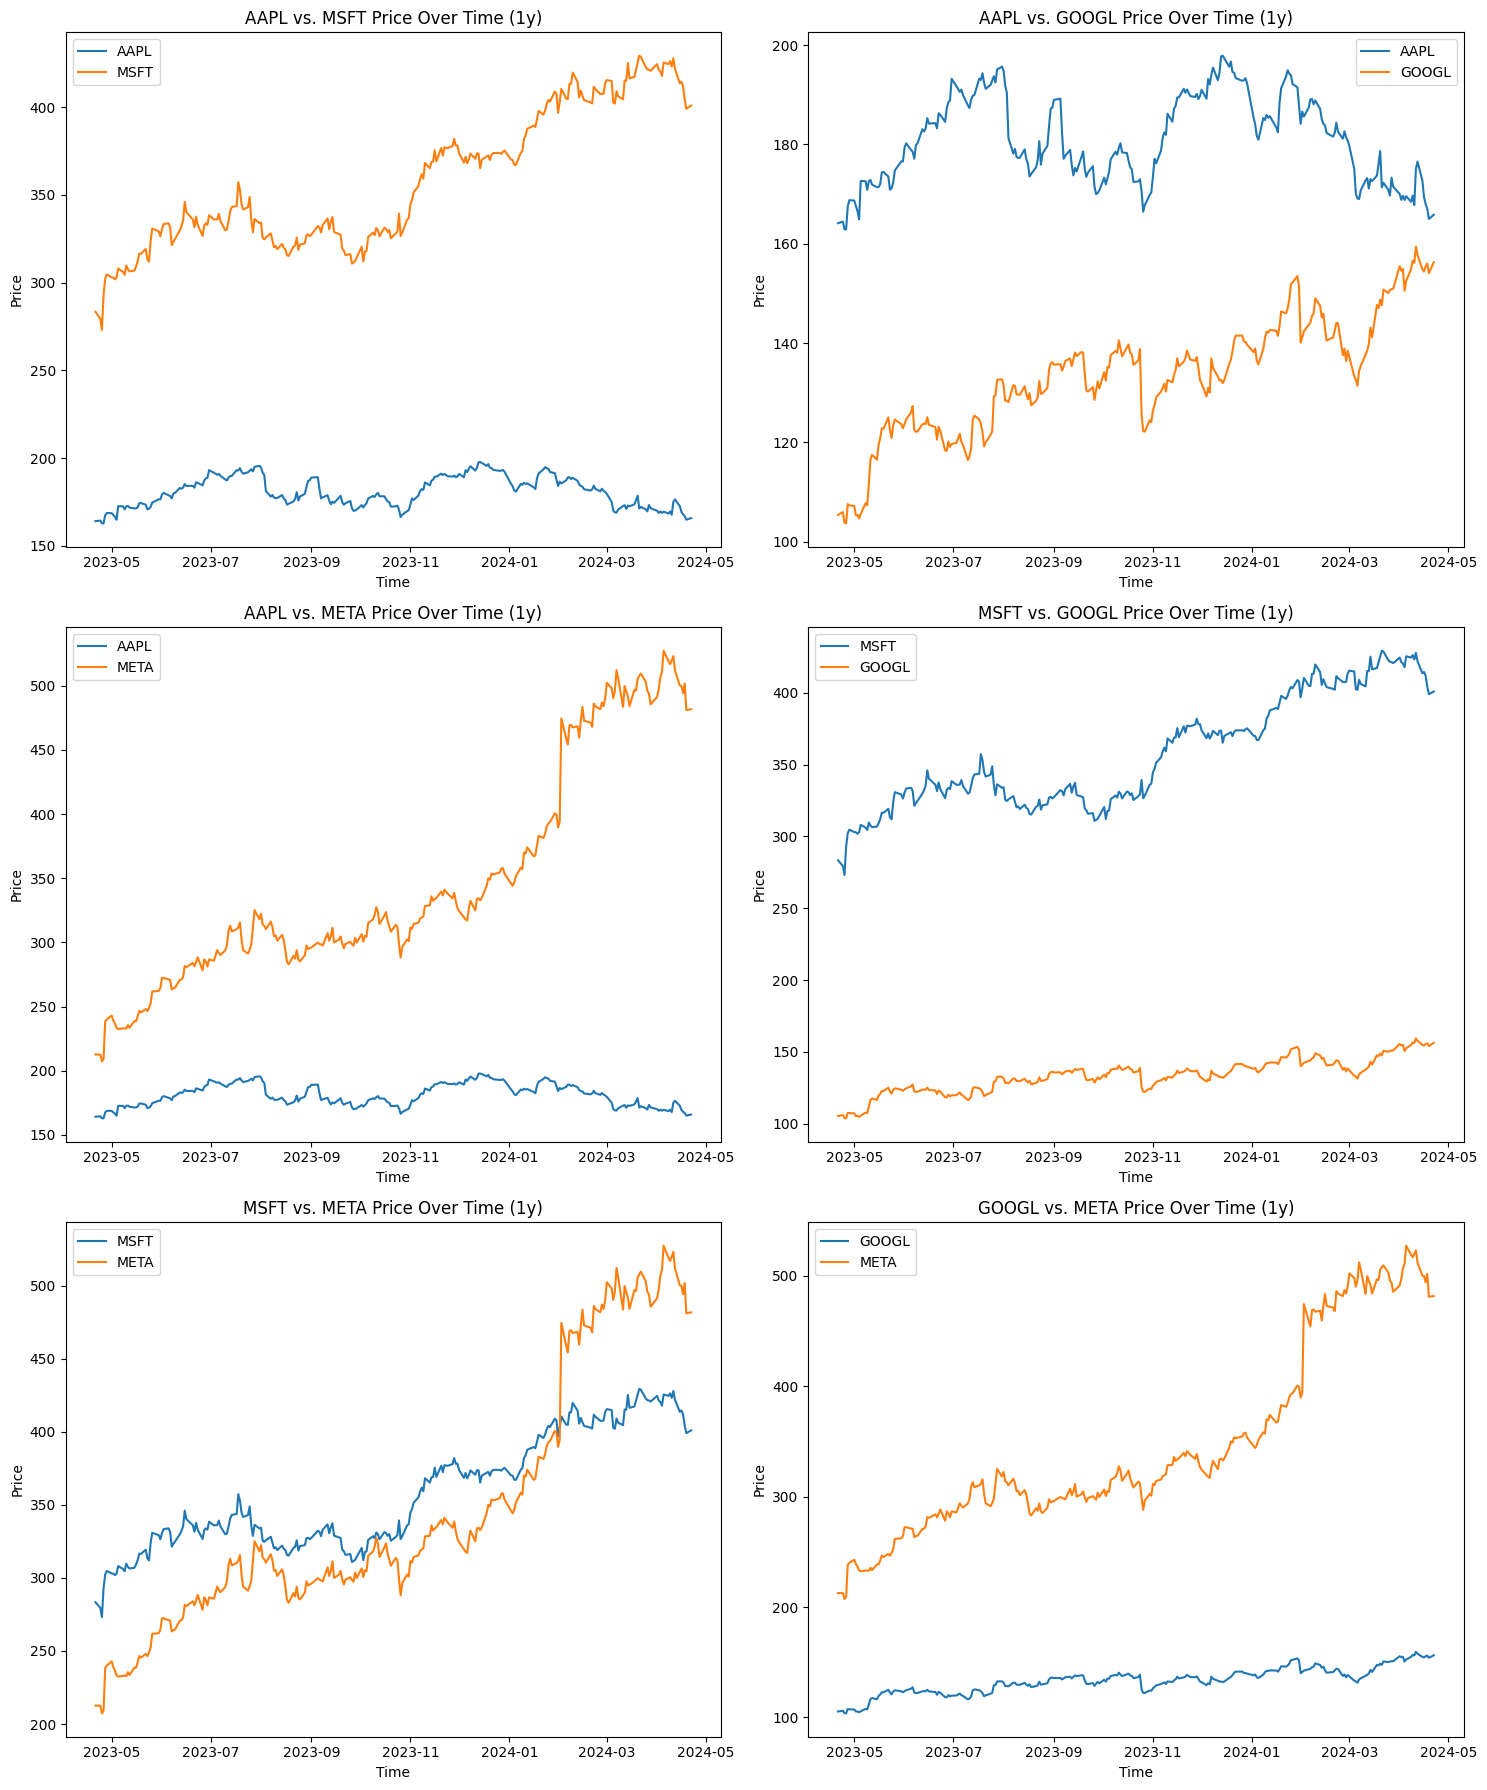

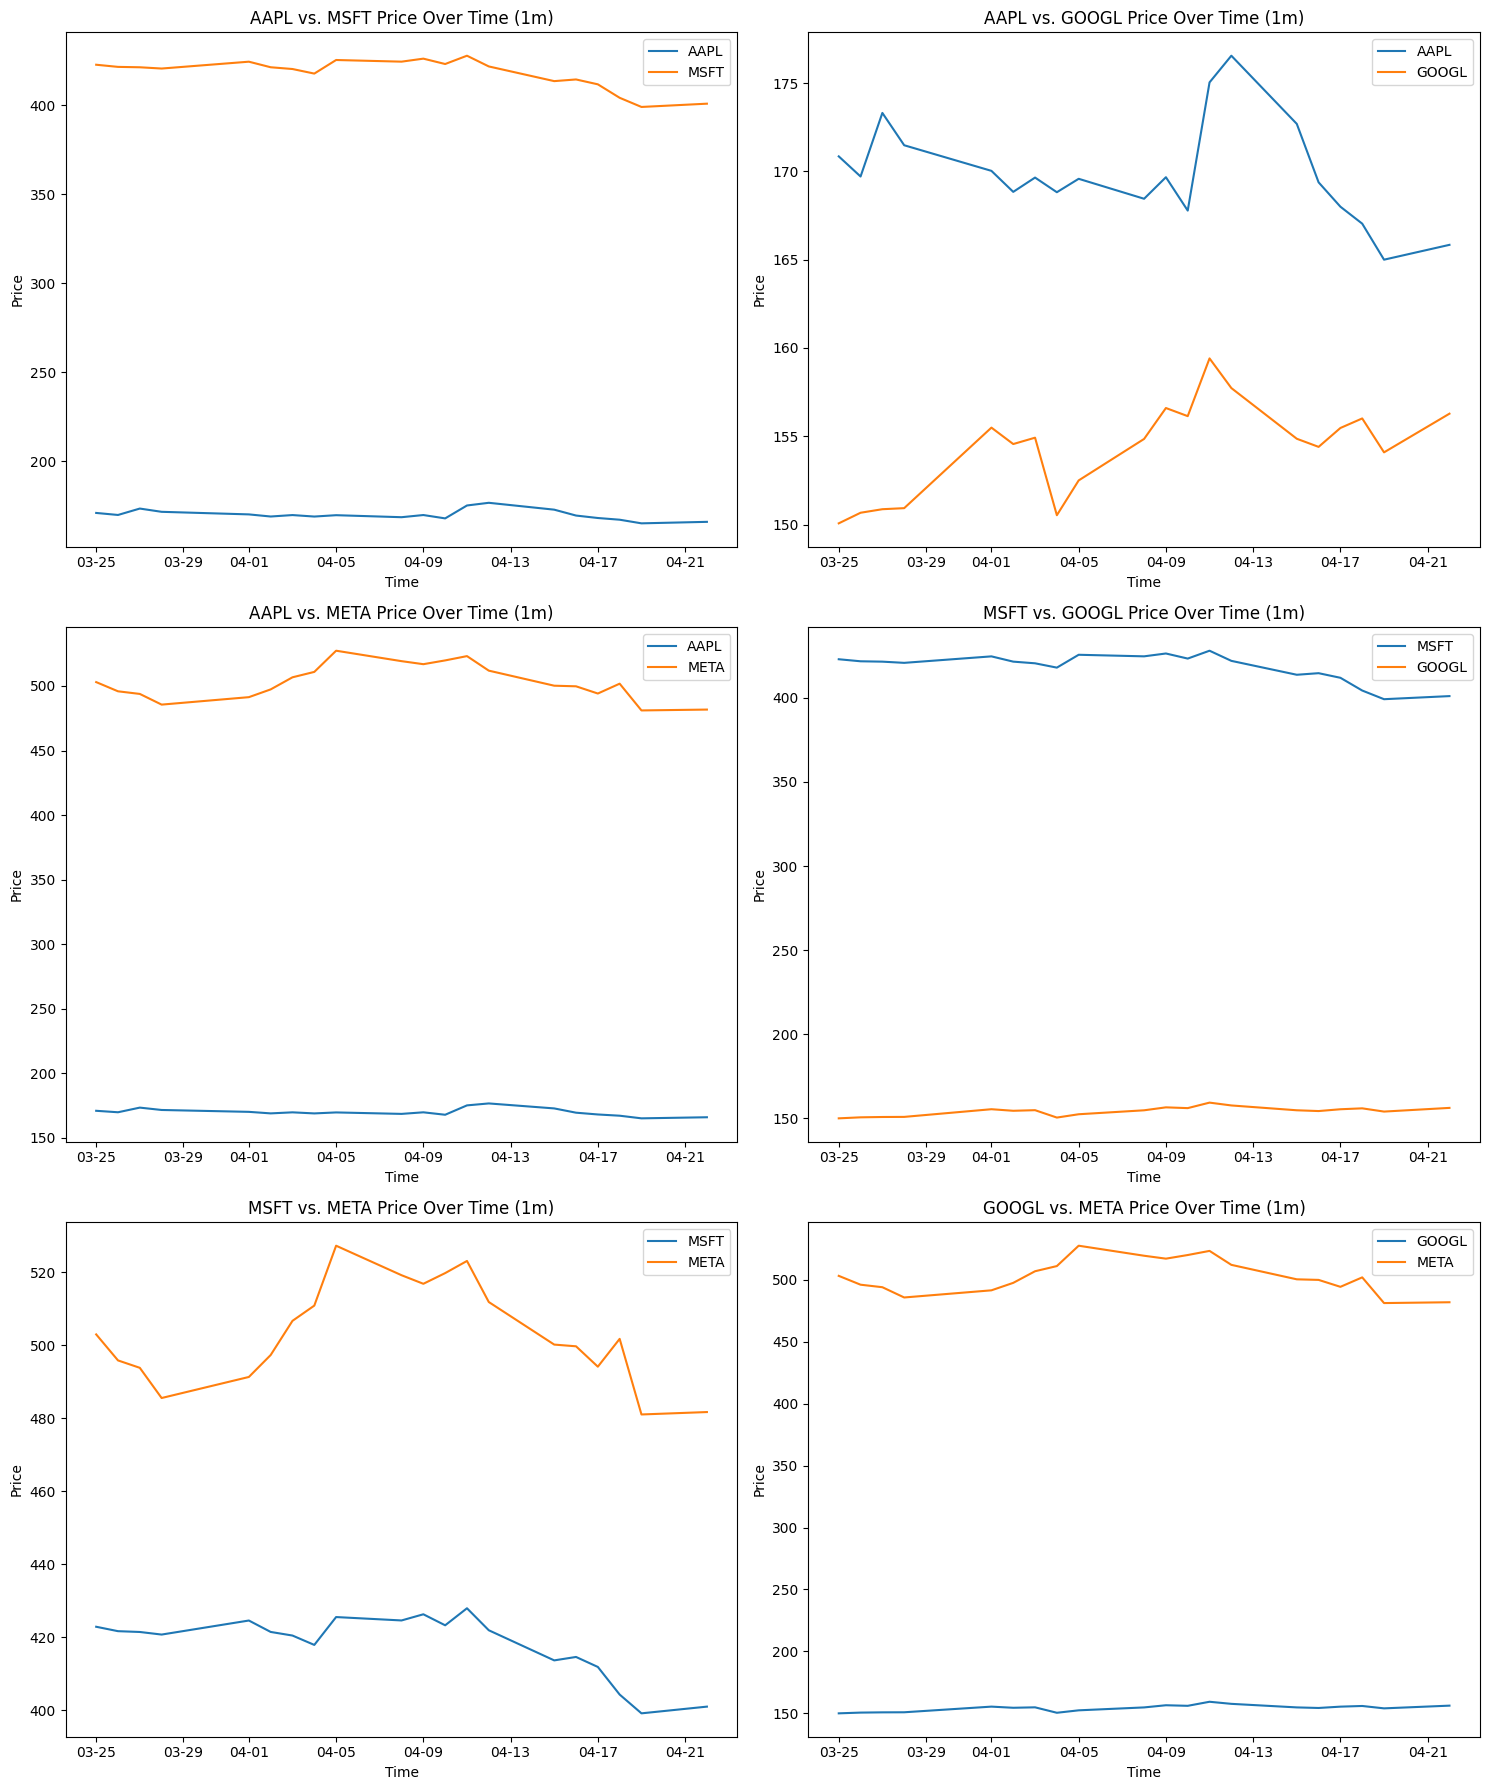

In [233]:
visualize_stock_tickers(data, tickers, '5y')
visualize_stock_tickers(data, tickers, '1y')
visualize_stock_tickers(data, tickers, '1m')


In [234]:
# Data analysis
for stock in tickers:
    if not test_stationarity(data[stock]):
        print(f'{stock} is not stationary')

results_df = granger_causality_test(data_log, tickers, periods=all_periods, max_lag=12)
styled_df = results_df.style.applymap(highlight_table_cells)
styled_df

['5y', '1y', '1m']

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2707  , p=0.6029  , df_denom=1255, df_num=1
ssr based chi2 test:   chi2=0.2714  , p=0.6024  , df=1
likelihood ratio test: chi2=0.2713  , p=0.6024  , df=1
parameter F test:         F=0.2707  , p=0.6029  , df_denom=1255, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3085  , p=0.2706  , df_denom=1252, df_num=2
ssr based chi2 test:   chi2=2.6275  , p=0.2688  , df=2
likelihood ratio test: chi2=2.6248  , p=0.2692  , df=2
parameter F test:         F=1.3085  , p=0.2706  , df_denom=1252, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8632  , p=0.4596  , df_denom=1249, df_num=3
ssr based chi2 test:   chi2=2.6042  , p=0.4568  , df=3
likelihood ratio test: chi2=2.6015  , p=0.4572  , df=3
parameter F test:         F=0.8632  , p=0.4596  , df_denom=1249, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:      

/var/folders/nx/scf6msw549j5lvz4kv2gfpz00000gn/T/ipykernel_34586/4017163888.py:7: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = results_df.style.applymap(highlight_table_cells)


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
"MSFT -> AAPL, (5y)",0.602940,0.270588,0.459594,0.042403,0.042677,0.026002,0.004647,0.000153,0.000513,0.000443,0.001154
"GOOGL -> AAPL, (5y)",0.610944,0.311693,0.414475,0.379215,0.327639,0.398877,0.023633,0.017022,0.029716,0.051291,nan
"META -> AAPL, (5y)",0.992726,0.767313,0.846527,0.896387,0.164564,0.180025,0.304939,0.311438,0.241371,0.237390,nan
"AAPL -> MSFT, (5y)",0.926237,0.210747,0.359388,0.037844,0.039049,0.059473,0.127616,0.104987,0.227924,0.202186,0.095982
"GOOGL -> MSFT, (5y)",0.391512,0.272169,0.430982,0.039956,0.078732,0.139685,0.168563,0.232458,0.345121,0.446052,nan
"META -> MSFT, (5y)",0.914471,0.886274,0.946214,0.915569,0.940154,0.982870,0.986099,0.990164,0.993183,0.982973,nan
"AAPL -> GOOGL, (5y)",0.155796,0.008667,0.023677,0.053578,0.070795,0.114575,0.236228,0.155771,0.182251,0.067602,nan
"MSFT -> GOOGL, (5y)",0.017044,0.004671,0.008572,0.009705,0.014803,0.001233,0.004664,0.007354,0.007080,0.004350,nan
"META -> GOOGL, (5y)",0.167118,0.186600,0.267986,0.306473,0.428740,0.391433,0.446262,nan,nan,nan,nan
"AAPL -> META, (5y)",0.849777,0.003587,0.010878,0.015326,0.004584,0.007144,0.014064,0.002402,0.010265,0.000055,nan


In [235]:
results_df_5y = granger_causality_test(data_log, tickers, periods=['5y'], max_lag=12)
styled_df = results_df.style.applymap(highlight_table_cells)
styled_df

['5y']



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2707  , p=0.6029  , df_denom=1255, df_num=1
ssr based chi2 test:   chi2=0.2714  , p=0.6024  , df=1
likelihood ratio test: chi2=0.2713  , p=0.6024  , df=1
parameter F test:         F=0.2707  , p=0.6029  , df_denom=1255, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3085  , p=0.2706  , df_denom=1252, df_num=2
ssr based chi2 test:   chi2=2.6275  , p=0.2688  , df=2
likelihood ratio test: chi2=2.6248  , p=0.2692  , df=2
parameter F test:         F=1.3085  , p=0.2706  , df_denom=1252, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8632  , p=0.4596  , df_denom=1249, df_num=3
ssr based chi2 test:   chi2=2.6042  , p=0.4568  , df=3
likelihood ratio test: chi2=2.6015  , p=0.4572  , df=3
parameter F test:         F=0.8632  , p=0.4596  , df_denom=1249, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4792  , p=0.

/var/folders/nx/scf6msw549j5lvz4kv2gfpz00000gn/T/ipykernel_34586/3744343073.py:2: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = results_df.style.applymap(highlight_table_cells)


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
"MSFT -> AAPL, (5y)",0.602940,0.270588,0.459594,0.042403,0.042677,0.026002,0.004647,0.000153,0.000513,0.000443,0.001154
"GOOGL -> AAPL, (5y)",0.610944,0.311693,0.414475,0.379215,0.327639,0.398877,0.023633,0.017022,0.029716,0.051291,nan
"META -> AAPL, (5y)",0.992726,0.767313,0.846527,0.896387,0.164564,0.180025,0.304939,0.311438,0.241371,0.237390,nan
"AAPL -> MSFT, (5y)",0.926237,0.210747,0.359388,0.037844,0.039049,0.059473,0.127616,0.104987,0.227924,0.202186,0.095982
"GOOGL -> MSFT, (5y)",0.391512,0.272169,0.430982,0.039956,0.078732,0.139685,0.168563,0.232458,0.345121,0.446052,nan
"META -> MSFT, (5y)",0.914471,0.886274,0.946214,0.915569,0.940154,0.982870,0.986099,0.990164,0.993183,0.982973,nan
"AAPL -> GOOGL, (5y)",0.155796,0.008667,0.023677,0.053578,0.070795,0.114575,0.236228,0.155771,0.182251,0.067602,nan
"MSFT -> GOOGL, (5y)",0.017044,0.004671,0.008572,0.009705,0.014803,0.001233,0.004664,0.007354,0.007080,0.004350,nan
"META -> GOOGL, (5y)",0.167118,0.186600,0.267986,0.306473,0.428740,0.391433,0.446262,nan,nan,nan,nan
"AAPL -> META, (5y)",0.849777,0.003587,0.010878,0.015326,0.004584,0.007144,0.014064,0.002402,0.010265,0.000055,nan


## Understanding Granger Causality

Statistical Concept: Granger causality is a statistical technique that examines whether past values of one time series (e.g., Stock A) help predict the future values of another time series (e.g., Stock B) beyond simply considering Stock B's own past values.

Not True Causality: It's crucial to remember that Granger causality doesn't imply a direct cause-and-effect relationship in the real-world sense. There might be other factors or complex market dynamics influencing the relationship.

## Stock Market Example

Let's say the Granger causality test shows that past values of "Stock A" Granger-cause "Stock B".  This could suggest a few possibilities:

Leading Indicator: Changes in Stock A might precede changes in Stock B.  Investors could potentially use Stock A's movements as a signal for potential future movements in Stock B.

Sector Influence: If Stock A and Stock B belong to the same sector, they might react similarly to common industry news or events. Stock A moving first might simply reflect its faster reaction to this shared driver.

Spurious Correlation: It's possible that the detected relationship is coincidental or due to some other hidden variable influencing both stocks.

## Interpreting Results

Your results table shows p-values for Granger causality tests between various stock pairs over different periods (5y, 1y, 1m) and at different lags. Here's how to generally interpret the p-values:

Lower p-value: A lower p-value (e.g., below 0.05) provides stronger evidence against the null hypothesis of no Granger causality. This suggests a potential predictive relationship worth investigating further.

Higher p-value:  A higher p-value (e.g., above 0.05) offers weaker evidence of Granger causality.

## Important Considerations

Multiple Lags: Examine the p-values across different lags. A pattern of lower p-values over consecutive lags might indicate a stronger lead-lag relationship.

Visualizations:  Your earlier visualizations would complement this analysis.  Look for visual patterns in the stock charts that might support or refute the causality suggested by the p-values.

Domain Knowledge: Always interpret your results in the context of your understanding of the specific stocks and the market.

## Example from Table

### Analyzing AAPL -> MSFT

Here's a breakdown of the AAPL -> MSFT p-values across different periods and lags in your results table:

5y: The p-values are generally high (above 0.05), with some dips below the threshold at specific lags. This suggests weak evidence of Granger causality over the longer term.
1y: Similar to the 5-year results, most p-values are high, indicating a lack of strong Granger causality in the recent year.
1m: Again, the p-values are mostly high.
Interpretation:  Based on these results, there's limited evidence to suggest that the past values of AAPL consistently help predict the future values of MSFT across the analyzed periods.

### Analyzing MSFT -> AAPL

5y: The first few lag values (lag_1, lag_2) have relatively high p-values, but there's a potential pattern of lower p-values as the lag increases. This might warrant further investigation.
1y: Similar to the 5y trend, the p-values decrease with increasing lag.
1m: The pattern observed in longer periods persists.
Interpretation: The MSFT -> AAPL direction seems to show slightly more potential for Granger causality, especially at higher lags in the 5-year and 1-year periods.  This could indicate a slower reaction of AAPL to potential leading signals from MSFT.  However, it's essential to investigate this further.

### GOOGL -> META

Let's look at the GOOGL -> META p-values in your table:

5y: Lower p-values are present across several lags, particularly in the middle of the lag range.
1y: The p-values remain low for several lags.
1m: In the most recent month, a few low p-values exist.
Interpretation: There seems to be some evidence suggesting that the past values of GOOGL might help predict future values of META.  This relationship appears somewhat more consistent across the different periods than the AAPL-MSFT pair.

## Important Reminders

Statistical, Not Causal: Granger causality is a statistical concept. Always consider potential real-world factors that might explain the observed patterns.
Visualizations: Refer back to your visualizations to see if they visually support the trends suggested by the Granger causality test.
Domain Knowledge: Your understanding of the tech sector and the dynamics between the companies is crucial for a contextual interpretation.

